# Dimensionality Reduction and Clustering

In this tutorial, we explore the process of analyzing and clustering time-series data for power consumption of a radiator. We will leverage methods such as Principal Component Analysis (PCA) for dimensionality reduction and K-means & DBSCAN for clustering. Along the way, we will visualize the data using scatter plots.

## Table of Contents
1. [Objectives](#objectives)
2. [Import Required Libraries](#import-required-libraries)
3. [Load and Preview the Data](#load-and-preview-the-data)
4. [Validate and Convert the Data](#validate-and-convert-the-data)
5. [Feature Extraction](#feature-extraction)
6. [Standardize the Features](#standardize-the-features)
7. [PCA for Dimensionality Reduction](#pca-for-dimensionality-reduction)
   - [Determine the Number of Components](#determine-the-number-of-components)
   - [Apply PCA with Optimal Components](#apply-pca-with-optimal-components)
8. [K-means Clustering](#k-means-clustering)
   - [Determine the Optimal Number of Clusters](#determine-the-optimal-number-of-clusters)
   - [Apply K-means with Optimal Clusters](#apply-k-means-with-optimal-clusters)
   - [Visualize K-means Clustering](#visualize-k-means-clustering)
9. [DBSCAN Clustering](#dbscan-clustering)
   - [Apply DBSCAN](#apply-dbscan)
   - [Visualize DBSCAN clustering](#visualize-dbscan-clustering)
10. [Conclusion](#conclusion)

## Objectives <a id="objectives">

This tutorial covers:

- Loading and preprocessing time-series data.
- Extracting features from the time-series data.
- Performing dimensionality reduction using Principal Component Analysis (PCA).
- Clustering data using K-means and DBSCAN.
- Visualizing results of dimensionality reduction and clustering.


## 2. Import Required Libraries <a id="import-required-libraries"></a>

The libraries below are used for this tutorial:

In [1]:
import pandas as pd
from interpreTS.utils.data_validation import validate_time_series_data
from interpreTS.utils.data_conversion import convert_to_time_series
from interpreTS.core.feature_extractor import FeatureExtractor, Features
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
import numpy as np

C:\Users\nisia\AppData\Roaming\Python\Python312\site-packages\dask\dataframe\__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Additionally, check the version of the `interpreTS` library:

In [2]:
import interpreTS
print(f"interpreTS version: {interpreTS.__version__}")

interpreTS version: 0.4.1


## Load and Preview the Data <a id="load-and-preview-the-data"></a>

Load the data containing time-series data for power consumption from the provided CSV file.

In [3]:
df = pd.read_csv('../data/radiator.csv')

Convert the `timestamp` column to datetime format and set it as the index:

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

Preview the dataset:

In [5]:
display(df)

,power
timestamp,
2020-12-23 16:42:05+00:00,1.0
2020-12-23 16:42:06+00:00,1.0
2020-12-23 16:42:07+00:00,1.0
2020-12-23 16:42:08+00:00,2.5
2020-12-23 16:42:09+00:00,3.0
...,...
2021-01-22 16:42:01+00:00,1178.0
2021-01-22 16:42:02+00:00,1167.0
2021-01-22 16:42:03+00:00,1178.0


Get information about the dataset:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2592001 entries, 2020-12-23 16:42:05+00:00 to 2021-01-22 16:42:05+00:00
Data columns (total 1 columns):
 #   Column  Dtype  
---  ------  -----  
 0   power   float64
dtypes: float64(1)
memory usage: 39.6 MB


## Validate and Convert the Data <a id="validate-and-convert-the-data"></a>

Ensure the dataset adheres to time-series data standards.

In [7]:
try:
    validate_time_series_data(df)
    print("Time series data validation passed.")
except (TypeError, ValueError) as e:
    print(f"Validation error: {e}")

Time series data validation passed.


Transform the dataset into a TimeSeriesData object, suitable for `interpreTS` functions:

In [8]:
time_series_data = convert_to_time_series(df)

Priview the converted TimeSeriesData object

In [9]:
print(time_series_data)
display(time_series_data.data)

,power
timestamp,
2020-12-23 16:42:05+00:00,1.0
2020-12-23 16:42:06+00:00,1.0
2020-12-23 16:42:07+00:00,1.0
2020-12-23 16:42:08+00:00,2.5
2020-12-23 16:42:09+00:00,3.0
...,...
2021-01-22 16:42:01+00:00,1178.0
2021-01-22 16:42:02+00:00,1167.0
2021-01-22 16:42:03+00:00,1178.0


## Feature Extraction <a id="feature-extraction"></a>

Initialize the FeatureExtractor to extract statistical and time-series features, such as mean, variance, and trend strength, using a sliding window approach with specified `window_size` and `stride`.

In [10]:
extractor = FeatureExtractor(
    features=[
        Features.MEAN, 
        Features.DOMINANT, 
        Features.TREND_STRENGTH, 
        Features.PEAK, 
        Features.VARIANCE
    ],
    window_size=60, 
    stride=30
)

Extract features from the time series data.

In [11]:
features = extractor.extract_features(time_series_data.data)

Display the extracted features.

In [12]:
display(features)

,mean_power,dominant_power,trend_strength_power,peak_power,variance_power
0,601.708333,1.0,0.755769,1314.0,421031.714336
1,775.850000,1182.7,0.484017,1314.0,402910.943220
2,176.033333,1.0,0.355786,1303.0,194327.422599
3,380.816667,1.0,0.633966,1314.0,347499.270904
4,808.200000,1182.8,0.009364,1314.0,359508.094915
...,...,...,...,...,...
86394,901.433333,1090.9,0.004244,1212.0,251057.775141
86395,1003.950000,1090.9,0.407723,1212.0,189202.150000
86396,1193.233333,1189.5,0.002166,1201.0,44.249718
86397,828.750000,1081.0,0.217282,1201.0,251538.936441


## Standardize the Features <a id="standardize-the-features"></a> 

Standardization ensures that all features have a mean of 0 and a standard deviation of 1, making them suitable for PCA and clustering.

In [13]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

## PCA for Dimensionality Reduction <a id="pca-for-dimensionality-reduction"></a>

### Determine the Number of Components <a id="determine-the-number-of-components"></a>

Perform PCA with all components.

In [14]:
pca = PCA()
pca_result = pca.fit_transform(features_scaled)

Calculate the cumulative explained variance ratio.

In [15]:
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

Plot the Scree Plot:

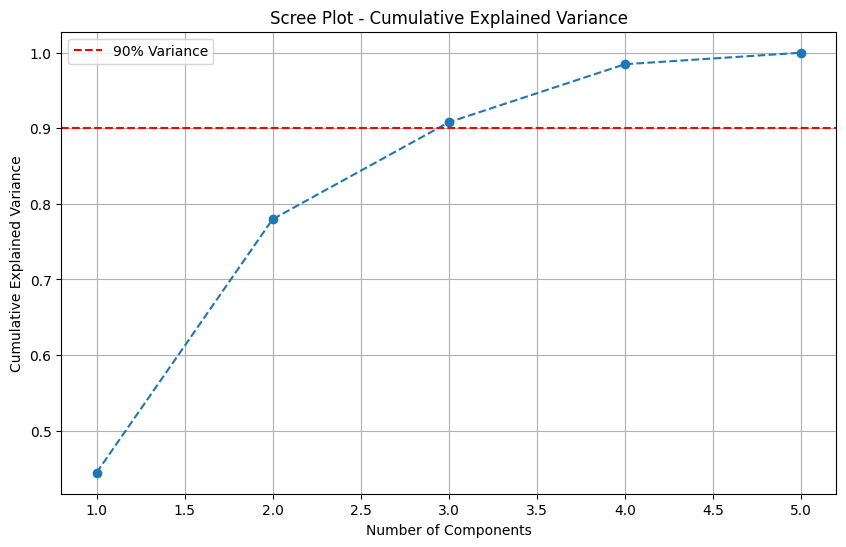

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance')
plt.title("Scree Plot - Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.legend()
plt.grid()
plt.show()

Determine the number of components required to explain at least 90% of the variance.

In [17]:
n_components_90 = np.argmax(explained_variance_ratio >= 0.9) + 1
print(f"Number of components explaining at least 90% variance: {n_components_90}")

Number of components explaining at least 90% variance: 3


### Apply PCA with Optimal Components<a id="apply-pca-with-optimal-components"></a>

Applies PCA to reduce the feature dimensions while retaining the maximum amount of information. Perform PCA with the optimal number of components.

In [18]:
pca_final = PCA(n_components=n_components_90)
pca_final_result = pca_final.fit_transform(features_scaled)

Get the PCA loadings (coefficients)

In [19]:
loadings = pca_final.components_
loading_df = pd.DataFrame(
    loadings.T, 
    columns=[f"PC{i+1}" for i in range(n_components_90)], 
    index=features.columns
)

To interpret the results of PCA, we display the PCA loadings. These loadings show how each feature contributes to the principal components.

In [20]:
display(loading_df)

,PC1,PC2,PC3
mean_power,-0.629927,0.181104,0.174236
dominant_power,-0.597785,0.165984,0.157005
trend_strength_power,0.008113,-0.590912,0.800670
peak_power,-0.492595,-0.366028,-0.351975
variance_power,-0.055940,-0.675646,-0.424303


Visualize the results in 3D to observe how data separates into clusters:

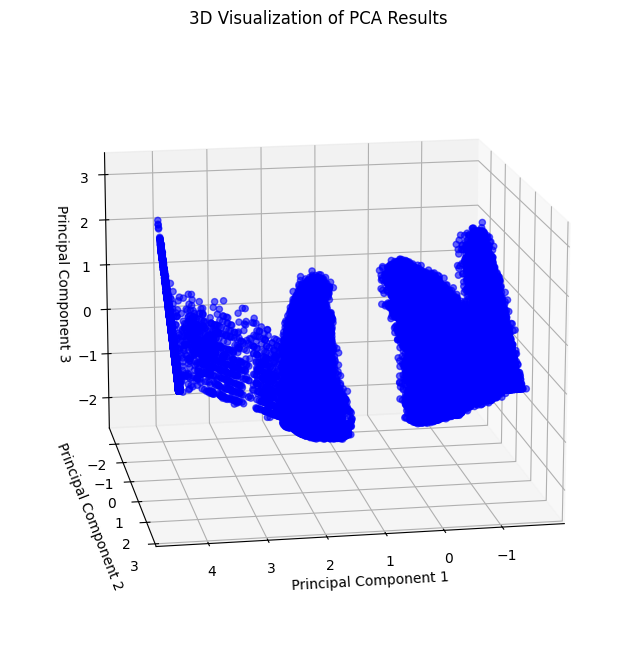

In [21]:
pca_df = pd.DataFrame(
    pca_final_result[:, :3], 
    columns=["PC1", "PC2", "PC3"]
)

x = pca_df["PC1"]
y = pca_df["PC2"]
z = pca_df["PC3"]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c='blue', alpha=0.6)
ax.set_title("3D Visualization of PCA Results")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.view_init(elev=15, azim=80)  
plt.show()

The following visualization provides a different perspective of the 3D PCA scatter plot.

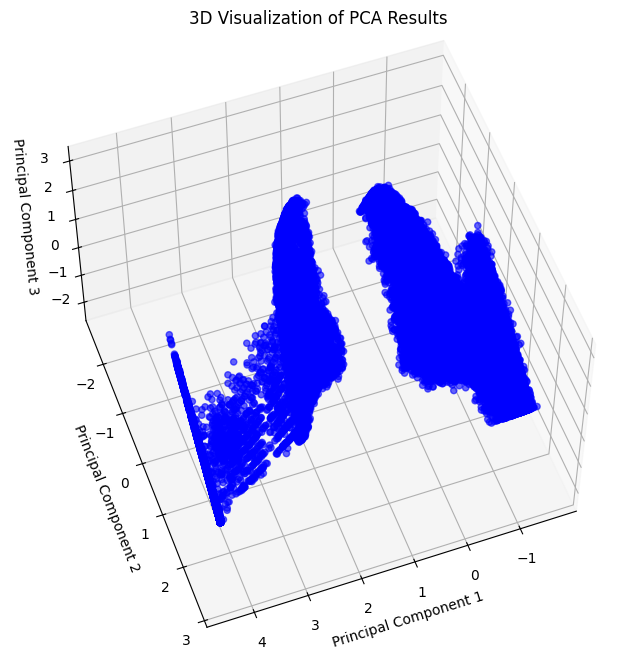

In [22]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c='blue', alpha=0.6)
ax.set_title("3D Visualization of PCA Results")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.view_init(elev=55, azim=70)  
plt.show()

**Observation:** The 3D PCA scatter plot reveals distinct groupings, suggesting the potential for clustering.



## K-means Clustering <a id="k-means-clustering"></a>

### Determine the Optimal Number of Clusters <a id="determine-the-optimal-number-of-clusters"></a>

Use the Elbow Method to find the optimal number of clusters

In [23]:
inertia = []
cluster_range = range(2, 6)  # Range of clusters to try

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_final_result)
    inertia.append(kmeans.inertia_)

Plot the Elbow Method

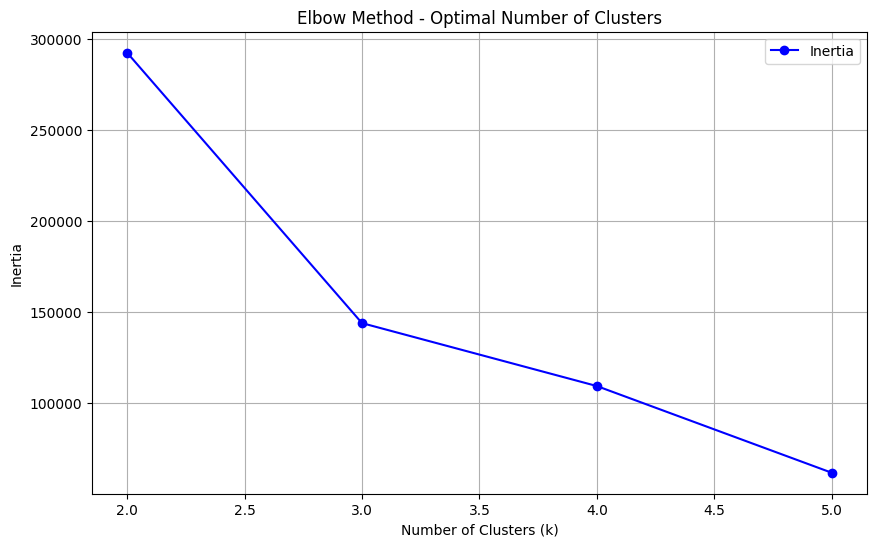

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia, 'bo-', label='Inertia')
plt.title("Elbow Method - Optimal Number of Clusters")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.legend()
plt.grid()
plt.show()

Interpretation: The "elbow" of the plot indicates the optimal number of clusters. For this data, the elbow occurs at k=3, suggesting three clusters.

### Apply K-means with Optimal Clusters <a id="apply-k-means-with-optimal-clusters"></a>

Based on the Elbow Method, K-Means is applied with k=3. Additionally, we experiment with a custom number of clusters (k=2) for comparison.

In [25]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(pca_final_result)


KMeans(n_clusters=3, random_state=42)

In [26]:
custom_k = 2
kmeans2 = KMeans(n_clusters=custom_k, random_state=42)
kmeans2.fit(pca_final_result)

KMeans(n_clusters=2, random_state=42)

K-means clustering labels

In [27]:
clusters = kmeans.labels_

In [28]:
clusters2 = kmeans2.labels_

### Visualize K-means Clustering <a id="visualize-k-means-clustering"></a>

Visualizes clustering results in 3D space because PCA reduced the number of columns to 3.

Visualization for `k=3`:


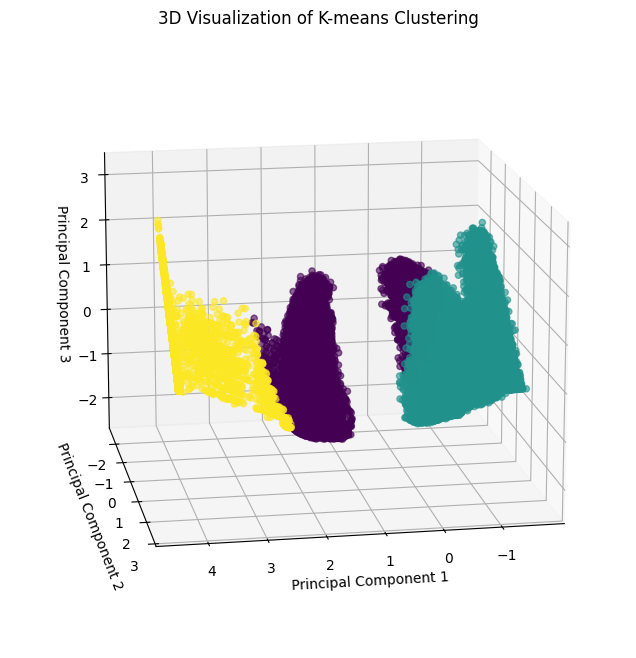

In [29]:
pca_df = pd.DataFrame(
    pca_final_result[:, :3], 
    columns=["PC1", "PC2", "PC3"]
)

x, y, z = pca_df["PC1"], pca_df["PC2"], pca_df["PC3"]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=clusters, cmap='viridis', alpha=0.6)
ax.set_title("3D Visualization of K-means Clustering")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.view_init(elev=15, azim=80)
plt.show()

Alternative Perspective:

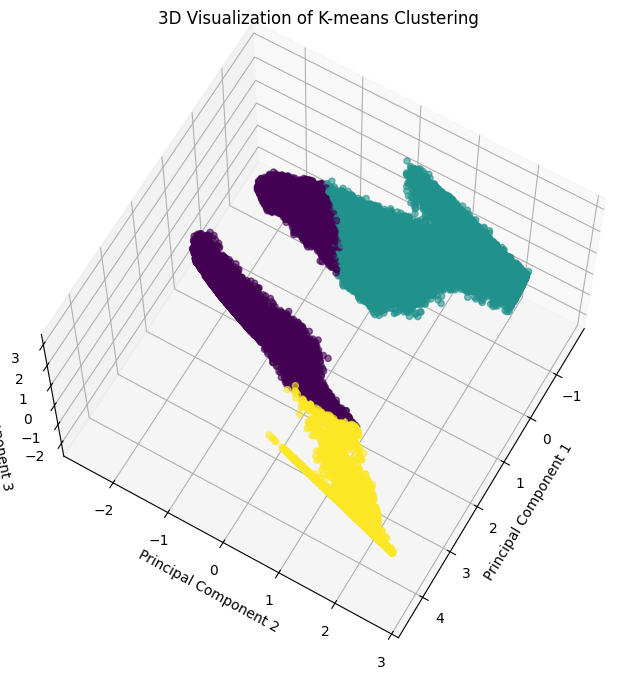

In [30]:
x, y, z = pca_df["PC1"], pca_df["PC2"], pca_df["PC3"]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=clusters, cmap='viridis', alpha=0.6)
ax.set_title("3D Visualization of K-means Clustering")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.view_init(elev=65, azim=30)
plt.show()

Visualization for `k=2`:

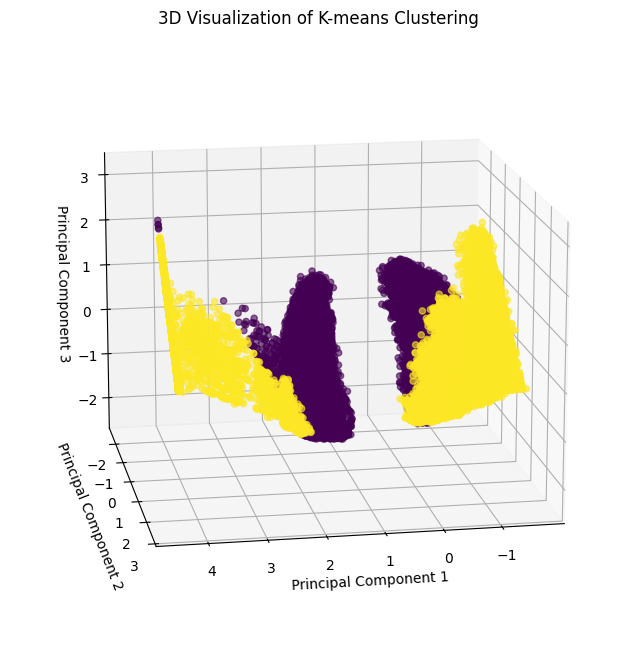

In [31]:
pca_df = pd.DataFrame(
    pca_final_result[:, :3], 
    columns=["PC1", "PC2", "PC3"]
)

x, y, z = pca_df["PC1"], pca_df["PC2"], pca_df["PC3"]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=clusters2, cmap='viridis', alpha=0.6)
ax.set_title("3D Visualization of K-means Clustering")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.view_init(elev=15, azim=80)
plt.show()

Alternative Perspective:

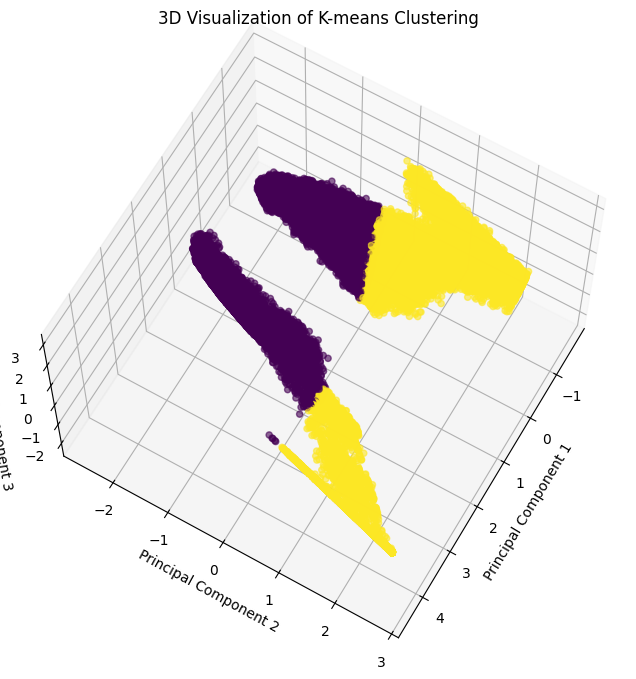

In [32]:
x, y, z = pca_df["PC1"], pca_df["PC2"], pca_df["PC3"]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=clusters2, cmap='viridis', alpha=0.6)
ax.set_title("3D Visualization of K-means Clustering")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.view_init(elev=65, azim=30)
plt.show()

## DBSCAN Clustering <a id="dbscan-clustering"></a>


### Apply DBSCAN <a id="apply-dbscan"></a>

DBSCAN clustering is applied to the data. This algorithm groups points based on density and handles non-linear clusters well. The parameters `eps` (maximum distance between points) and `min_samples` (minimum points in a neighborhood) require tuning for optimal performance.

In [33]:
dbscan = DBSCAN(eps=0.5, min_samples=15)
dbscan_labels = dbscan.fit_predict(pca_final_result)

### Visualize DBSCAN clustering <a id="visualize-dbscan-clustering"></a>

The clustering results are visualized in 3D space using the three principal components.

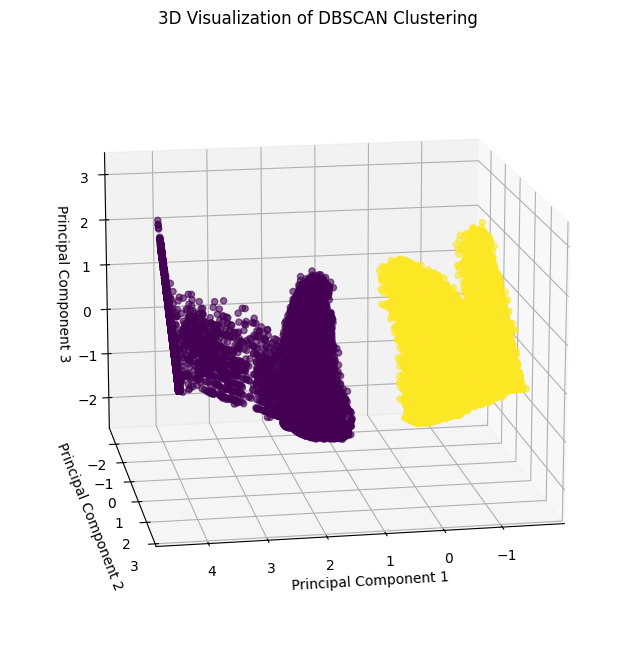

In [34]:
x, y, z = pca_final_result[:, 0], pca_final_result[:, 1], pca_final_result[:, 2]
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x, y, z, c=dbscan_labels, cmap='viridis', alpha=0.6)
ax.set_title("3D Visualization of DBSCAN Clustering")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
ax.view_init(elev=15, azim=80)
plt.show()


## Conclusion
- **K-Means**: Identifies global clusters but may struggle with non-linear shapes.
- **DBSCAN**:  Handles non-linear clusters and noise effectively but requires parameter tuning.
- **PCA** proved valuable for visualization and clustering.

This analysis illustrates the power of `interpreTS` in feature extraction and clustering for time-series data.